In [2]:
import numpy as np
import os
import arc
import importlib
importlib.reload(arc)
import json
import pandas as pd
import pickle


shelf_name='brunt-riiser-ekstrom'

atl06_file_name = './atl06_' + shelf_name + '.pkl'
atl06_filelist = './filelists/' + shelf_name + '-list.json'
dataset_path = '/data/fast0/'


# Load data (deserialize)
with open(atl06_file_name, 'rb') as handle:
    atl06_data = pickle.load(handle)
    print('ATL06 data loaded from pickle.')



ATL06 data loaded from pickle.


[(23, 30), (54, 69), (80, 91), (92, 96), (175, 178), (307, 314), (319, 325), (378, 384), (387, 392), (491, 512), (513, 515), (528, 533), (534, 541), (546, 557), (582, 585), (1788, 1789), (2615, 2623)]


(0.0, 300.0)

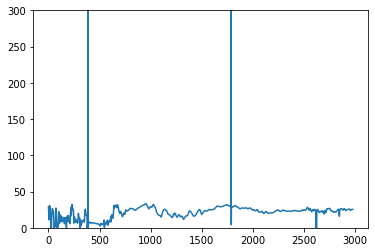

In [43]:
# for i, row in atl06_data.iterrows():
row = atl06_data.iloc[3]

rift_list = arc.find_the_rifts(row['h'])
print(rift_list)

import matplotlib.pyplot as plt
plt.plot(row['h'])
plt.ylim((0,300))